In [1]:
import cvxpy as cp
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
class solve_PMK:
    def __init__(self, rho0, rho1, n, gamma, tau):
        self.rho0 = rho0 
        self.rho1 = rho1
        self.n = n
        self.gamma = gamma
        self.tau = tau
        self.dx = 1/(n - 1)
        self.nu = 1/(4*self.tau)
        self.mu = 1/(32*(self.n - 1)**2*self.tau)
        self.variables = ['m', 'rho0t', 'rho1t', 'Phi']
        self.custom_data = {}
        self.objectives = None
        self.cvxpy_solution = None
        self.custom_solution = None
        self.Rs = []
        assert np.sum(self.rho1) >= np.sum(self.rho0), "rho0 has greater mass than rho1"
    
    def solve_with_cvxpy(self):
        n = self.n
        dx = self.dx
        p0 = self.rho0
        p1 = self.rho1
        gamma = self.gamma
        
        mx = cp.Variable((n-1,n))
        my = cp.Variable((n,n-1))
        p0t = cp.Variable((n,n))
        p1t = cp.Variable((n,n))
        col0 = np.zeros((n,1))
        row0 = np.zeros((1,n))

        objective = cp.Minimize(cp.sum(cp.norm(cp.vstack([cp.vec(cp.hstack([my, col0])), cp.vec(cp.vstack([mx, row0]))]),axis=0)))

        # Assumes that p1t has larger mass
        constraints = [
            dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
            p0t >= 0,
            p0t <= p0,
            p1t >= 0,
            p1t <= p1,
            cp.sum(p0t) == gamma,
            cp.sum(p1t) == gamma,
        ]
        prob = cp.Problem(objective, constraints)
        prob_val = prob.solve()
        self.cvxpy_solution = self.Solution(p0t.value, p1t.value, prob.solver_stats.solve_time, prob.solver_stats.num_iters, prob_val)
    
    def get_random_init(self):
        n = self.n
        mx = np.random.normal(size=(n-1,n))
        my = np.random.normal(size=(n,n-1))
        rho0t = np.random.normal(size=(n,n))
        rho1t = np.random.normal(size=(n,n))
        Phi = np.random.normal(size=(n,n))
        return mx, my, rho0t, rho1t, Phi
    
    def get_feasible_init(self):
        n = self.n
        dx = self.dx
        gamma = self.gamma
        p0 = self.rho0
        p1 = self.rho1
        mx = cp.Variable((n-1,n))
        my = cp.Variable((n,n-1))
        p0t = cp.Variable((n,n))
        p1t = cp.Variable((n,n))
        col0 = np.zeros((n,1))
        row0 = np.zeros((1,n))

        objective = cp.Minimize(1)

        # Assumes that p1t has larger mass
        constraints = [
            dx*(p0t - p1t) == cp.vstack([mx,row0])-cp.vstack([row0,mx])+cp.hstack([my,col0])-cp.hstack([col0,my]),
            p0t >= 0,
            p0t <= p0,
            p1t >= 0,
            p1t <= p1,
            cp.sum(p0t) == gamma,
            cp.sum(p1t) == gamma,
        ]
        prob = cp.Problem(objective, constraints)
        prob_val = prob.solve()
        return mx.value, my.value, p0t.value, p1t.value, np.random.normal(size=(n,n))
    
    def project_onto_density(self, sigma, rho, gamma, epsilon=1e-5):
        theta_min = -np.max(rho) + np.min(sigma)
        theta_max = np.max(sigma)
        theta_mid = None
        while theta_max - theta_min >= epsilon:
            theta_mid = (theta_max + theta_min) / 2
            rho_t = np.minimum(np.maximum(sigma-theta_mid,0),rho)
            if gamma < np.sum(rho_t):
                theta_min = theta_mid
            else:
                theta_max = theta_mid
        return np.minimum(np.maximum(sigma-theta_mid,0),rho)

    def discrete_gradient(self, Phi):
        dx = self.dx
        n = self.n
        dPhi_x = (Phi[1:,:] - Phi[:-1,:]) / dx
        dPhi_y = (Phi[:,1:] - Phi[:,:-1]) / dx
        return dPhi_x, dPhi_y

    def discrete_div(self, mx, my):
        dx = self.dx
        col0 = np.zeros((n,1))
        row0 = np.zeros((1,n))
        return (np.vstack((mx,row0))-np.vstack((row0,mx))+np.hstack((my,col0))-np.hstack((col0,my))) / dx

    def shrink2(self, X, Y):
        mu = self.mu
        n = self.n
        col0 = np.zeros((n,1))
        row0 = np.zeros((1,n))
        ghost = np.array([np.vstack((X, row0)), np.hstack((Y, col0))])
        norms = np.linalg.norm(ghost, axis=0)
        c = np.zeros_like(norms)
        for i in range(n):
            for j in range(n):
                if norms[i,j] >= mu:
                    c[i,j] = 1-mu/norms[i,j]
        y = ghost*c
        return y[0,:-1,:], y[1,:,:-1]

    def objective(self, mx, my):
        n = self.n
        col0 = np.zeros((n,1))
        row0 = np.zeros((1,n))
        return np.sum(np.linalg.norm(np.vstack((np.hstack([my, col0]).reshape(1,-1), np.vstack([mx, row0]).reshape(1,-1))),axis=0))

    def solve(self, random_init=True, eps=1e-11):
        rho0 = self.rho0
        rho1 = self.rho1
        gamma = self.gamma
        dx = self.dx
        mu = self.mu
        nu = self.nu
        tau = self.tau
        n = self.n
        self.Rs = []
        start = time.time()
        mx, my, rho00_t, rho10_t, Phi0 = self.get_random_init()
        if not random_init:
            mx, my, rho00_t, rho10_t, Phi0 = self.get_feasible_init()
        m_list = [(mx, my)]
        rho0_t_list = [rho00_t]
        rho1_t_list = [rho10_t]
        Phi_list = [Phi0]
        objectives = []
        ct = 0
        R = None
        while True:
            objectives.append(self.objective(m_list[-1][0], m_list[-1][1]))
            if len(objectives) >= 2:
                if ct % 1000 == 0:
                    print("Iteration", ct, "Objective value is", objectives[-1], "and R is", R)
                if R < eps:
                    print("Iteration", ct, "Converged with objective value", objectives[-1])
                    break
            ct += 1
            dPhi_x, dPhi_y = self.discrete_gradient(Phi_list[-1])
            mx_next, my_next = self.shrink2(m_list[-1][0]+mu*dPhi_x, m_list[-1][1]+mu*dPhi_y)
            rho0_t_next = self.project_onto_density(rho0_t_list[-1]+nu*Phi_list[-1], self.rho0, self.gamma)
            rho1_t_next = self.project_onto_density(rho1_t_list[-1]-nu*Phi_list[-1], self.rho1, self.gamma)
            Phi_next = Phi_list[-1] + tau*(
                self.discrete_div(2*mx_next - m_list[-1][0], 2*my_next - m_list[-1][1])
                 + 2*rho1_t_next - rho1_t_list[-1]
                 - 2*rho0_t_next + rho0_t_list[-1]
            )
            R = (np.sum((mx_next-m_list[-1][0]).flatten()**2) 
                 + np.sum((my_next-m_list[-1][1]).flatten()**2))/mu
            + (np.sum((rho0_t_next - rho0_t_list[-1]).flatten()**2)
               + np.sum((rho1_t_next - rho1_t_list[-1]).flatten()**2))/nu
            + np.sum((Phi_next - Phi_list[-1])**2)/tau
            - 2*np.sum((Phi_next - Phi_list[-1])*(
                self.discrete_div(mx_next-m_list[-1][0],my_next-m_list[-1][1])
                + rho1_t_next - rho1_t_list[-1] - rho0_t_next + rho0_t_list[-1]
            )
                      )
            m_list.append((mx_next, my_next))
            rho0_t_list.append(rho0_t_next)
            rho1_t_list.append(rho1_t_next)
            Phi_list.append(Phi_next)
            self.Rs.append(R)
        end = time.time()
        self.custom_data['m'] = m_list
        self.custom_data['rho0t'] = rho0_t_list
        self.custom_data['rho1t'] = rho1_t_list
        self.custom_data['Phi'] = Phi_list
        self.objectives = objectives
        self.custom_solution = self.Solution(self.custom_data['rho0t'][-1], self.custom_data['rho1t'][-1], end-start, ct, self.objectives[-1])
    
    def compare_methods(self):
        fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, constrained_layout=True)
        fig.set_size_inches(9, 6)
        ax0.imshow(self.rho0)
        ax3.imshow(self.rho1)
        ax1.imshow(self.cvxpy_solution.rho0t)
        ax4.imshow(self.cvxpy_solution.rho1t)
        ax2.imshow(self.custom_solution.rho0t)
        ax5.imshow(self.custom_solution.rho1t)
        ax0.title.set_text(r"$\rho_0$")
        ax3.title.set_text(r"$\rho_1$")
        ax1.title.set_text(r"$\tilde{\rho_0}$ from CVXPY")
        ax4.title.set_text(r"$\tilde{\rho_1}$ from CVXPY")
        ax2.title.set_text(r"$\tilde{\rho_0}$ from Chambolle-Pock")
        ax5.title.set_text(r"$\tilde{\rho_1}$ from Chambolle-Pock")
        ax0.set_axis_off()
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax3.set_axis_off()
        ax4.set_axis_off()
        ax5.set_axis_off()
        print(f"CVXPY obtained value {self.cvxpy_solution.objective:.6f} and used {self.cvxpy_solution.solve_time:.6f}s and {self.cvxpy_solution.num_iters} iterations, with each iteration taking {self.cvxpy_solution.time_per_iter():.6f}s")
        print(f"Chambolle-Pock obtained value {self.custom_solution.objective:.6f} and used {self.custom_solution.solve_time:.6f}s and {self.custom_solution.num_iters} iterations, with each iteration taking {self.custom_solution.time_per_iter():.6f}s")
        
    def custom_methods(self):
        fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, constrained_layout=True)
        fig.set_size_inches(8, 8)
        ax0.imshow(self.rho0)
        ax2.imshow(self.rho1)
        ax1.imshow(self.custom_solution.rho0t)
        ax3.imshow(self.custom_solution.rho1t)
        ax0.title.set_text(r"$\rho_0$")
        ax2.title.set_text(r"$\rho_1$")
        ax1.title.set_text(r"$\tilde{\rho_0}$ from Chambolle-Pock")
        ax3.title.set_text(r"$\tilde{\rho_1}$ from Chambolle-Pock")
        ax0.set_axis_off()
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax3.set_axis_off()
        print(f"Chambolle-Pock obtained value {self.custom_solution.objective:.6f} and used {self.custom_solution.solve_time:.6f}s and {self.custom_solution.num_iters} iterations, with each iteration taking {self.custom_solution.time_per_iter():.6f}s")
    
    def custom_stats(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='row', constrained_layout=True)
        fig.set_size_inches(10, 4)
        m = self.custom_data['m']
        rho0t = self.custom_data['rho0t']
        rho1t = self.custom_data['rho1t']
        dx = self.dx
        res = (np.array([np.sum(np.abs((rho0t[i]-rho1t[i])-self.discrete_div(m[i][0],m[i][1]))) for i in range(len(rho0t))]))[len(self.objectives)//10+5000:]
        ax1.plot(self.objectives[len(self.objectives)//10+5000:])
        ax2.plot(res)
        ax3.plot(self.Rs[len(self.objectives)//10+5000:])
        ax1.title.set_text('Objective function')
        ax2.title.set_text('Divergence constraint residual')
        ax3.title.set_text('Termination criterion')
        fig.suptitle("Chambolle-Pock Solver Data")
    
    class Solution:
        def __init__(self, rho0t, rho1t, solve_time, num_iters, objective):
            self.rho0t = rho0t
            self.rho1t = rho1t
            self.solve_time = solve_time
            self.num_iters = num_iters
            self.objective = objective
        
        def time_per_iter(self):
            return self.solve_time/self.num_iters
        

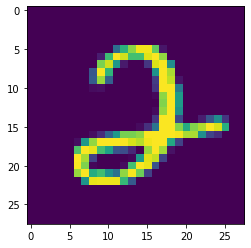

In [3]:
import gzip
f = gzip.open('train-images-idx3-ubyte.gz','r')

image_size = 28
num_images = 100

f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
data = data.reshape(num_images, image_size, image_size, 1)
image = np.asarray(data[16]).squeeze()
plt.imshow(image)

In [4]:
rho1 = np.asarray(data[0]).squeeze()
rho0 = np.asarray(data[4]).squeeze()
assert np.sum(rho1) >= np.sum(rho0)
norm_factor = max(np.sum(rho1), np.sum(rho0))
rho1 = rho1 / norm_factor
rho0 = rho0 / norm_factor
print(np.sum(rho1), np.sum(rho0))

1.0 0.8433788


In [3]:
n = 100
tau = 1e-2
gamma = 0.6

In [5]:
n=28
tau=1e-2
gamma=0.7

In [4]:
import imageio
rho0 = np.pad(255-np.asarray(imageio.imread('2.png')),((5,4),(17,18)))
rho1 = np.pad(255-np.asarray(imageio.imread('30.png')),((4,3),(6,6)))

assert np.sum(rho1) >= np.sum(rho0)
norm_factor = max(np.sum(rho1), np.sum(rho0))
rho1 = rho1 / norm_factor
rho0 = rho0 / norm_factor
print(np.sum(rho1), np.sum(rho0))

1.0 0.7192864501865741


In [11]:
solver = solve_PMK(rho0, rho1, n, gamma, tau)

In [27]:
solver.solve(random_init=True,eps=1e-12)

Iteration 1000 Objective value is 0.01678672742512674 and R is 3.850592240849489e-07
Iteration 2000 Objective value is 0.029876618414978802 and R is 5.705845324241523e-08
Iteration 3000 Objective value is 0.035425723750436525 and R is 4.7342309043817786e-08
Iteration 4000 Objective value is 0.03909940863177126 and R is 3.871219549536647e-08
Iteration 5000 Objective value is 0.04018019797594723 and R is 3.5768802256979894e-08
Iteration 6000 Objective value is 0.041438978020098584 and R is 1.513733757201398e-08
Iteration 7000 Objective value is 0.042263945287046314 and R is 5.433201392885193e-09
Iteration 8000 Objective value is 0.04372009381812196 and R is 2.5356577774588114e-09
Iteration 9000 Objective value is 0.04425572963201874 and R is 8.462342638784114e-10
Iteration 10000 Objective value is 0.04446482649490202 and R is 1.1297851851659198e-08
Iteration 11000 Objective value is 0.044855008020339544 and R is 9.008079696368135e-10
Iteration 12000 Objective value is 0.04467422354337839

In [33]:
solver.solve_with_cvxpy()

CVXPY obtained value 0.046339 and used 0.166607s and 58 iterations, with each iteration taking 0.002873s
Chambolle-Pock obtained value 0.045551 and used 18.100947s and 18044 iterations, with each iteration taking 0.001003s


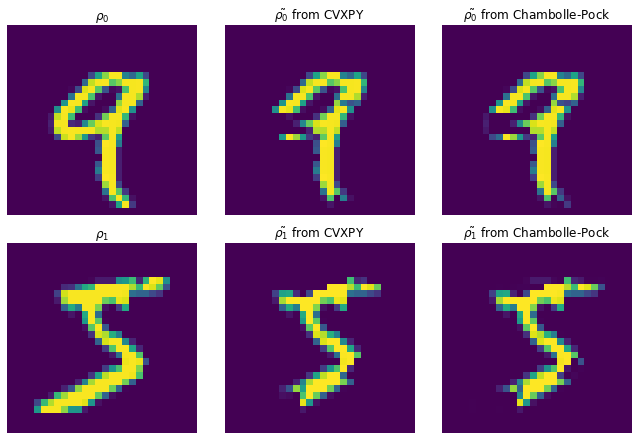

In [34]:
solver.compare_methods()

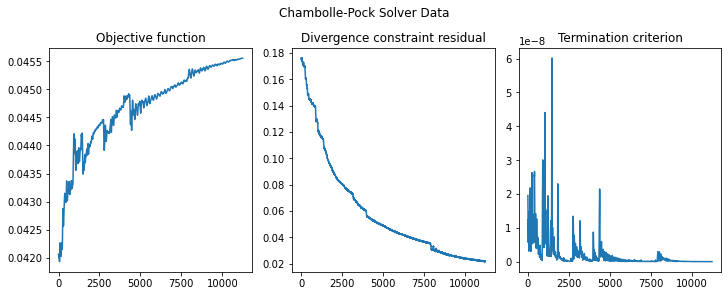

In [35]:
solver.custom_stats()